<a href="https://colab.research.google.com/github/gnouvj/AQI_analysis/blob/main/ProjectCode_CMPE255.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Library

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import folium
from folium.plugins import HeatMap
from google.cloud import bigquery
from google.colab import auth
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go

### Provide your Google Cloud credentials to the runtime

In [2]:
auth.authenticate_user()
print('Authenticated')

Authenticated


## Optional: Enable data table display

Colab includes the ``google.colab.data_table`` package that can be used to display large pandas dataframes as an interactive data table.
It can be enabled with:

In [3]:
%load_ext google.colab.data_table

If you would prefer to return to the classic Pandas dataframe display, you can disable this by running:
```python
%unload_ext google.colab.data_table
```

Declare the Cloud project ID which will be used throughout this notebook

In [4]:
project_id = 'cmpe255-project-419122'

In [5]:
!gcloud config list

[component_manager]
disable_update_check = True
[core]
account = kwanqing.ong@sjsu.edu

Your active configuration is: [default]


In [6]:
#!gcloud config set compute/region us-central1
#!gcloud config set compute/zone us-central1-a
!gcloud config list project

[core]
project (unset)

Your active configuration is: [default]


In [7]:
!gcloud config set project 'cmpe255-project-419122'

Updated property [core/project].


In [8]:
!gcloud config list project

[core]
project = cmpe255-project-419122

Your active configuration is: [default]


In [9]:
# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'cmpe255-project-419122'
client = bigquery.Client(project=project_id)

#Print your current data
for dataset in client.list_datasets():
  print(dataset.dataset_id)

aqi_trend_analysis_dataset


# AQI Trend Analysis Dataset


## Data Processing

In [ ]:
# Path to the directory where all your CSV files are stored
csv_directory = '/content/'

# List to hold data from each CSV
dataframes_list = []

# Loop through all the CSV files in the directory
for filename in os.listdir(csv_directory):
    if filename.endswith('.csv'):
        # Construct the full file path
        filepath = os.path.join(csv_directory, filename)
        # Read the CSV file and append it to the list
        df = pd.read_csv(filepath)
        dataframes_list.append(df)

# Concatenate all DataFrames in the list into one
annual_aqi_by_county_df = pd.concat(dataframes_list, ignore_index=True)

# Optionally, you can save the merged DataFrame to a new CSV file
annual_aqi_by_county_df.to_csv('/content/annual_aqi_by_county.csv', index=False)

# Display the shape of the merged DataFrame to confirm
print(f"Merged DataFrame shape: {annual_aqi_by_county_df.shape}")

annual_aqi_by_county_df.head()

In [ ]:
annual_aqi_by_county_df = pd.read_csv('/content/annual_aqi_by_county.csv')
annual_aqi_by_county_df.head()

State   County  Year  Days with AQI  Good Days  Moderate Days  \
0  Alabama  Baldwin  2016            279        247             32   
1  Alabama     Clay  2016            116        109              7   
2  Alabama  Colbert  2016            282        258             23   
3  Alabama   DeKalb  2016            348        304             43   
4  Alabama   Elmore  2016            117        107             10   

   Unhealthy for Sensitive Groups Days  Unhealthy Days  Very Unhealthy Days  \
0                                    0               0                    0   
1                                    0               0                    0   
2                                    1               0                    0   
3                                    1               0                    0   
4                                    0               0                    0   

   Hazardous Days  Max AQI  90th Percentile AQI  Median AQI  Days CO  \
0               0       87                   51          37        0   
1               0       56                   45          30        0   
2               0      115                   50          38        0   
3               0      119                   54          40        0   
4               0       77                   48          40        0   

   Days NO2  Days Ozone  Days PM2.5  Days PM10  
0         0         221          58          0  
1         0           0         116          0  
2         0         219          63          0  
3         0         321          27          0  
4         0         117           0          0

In [ ]:
# Rename columns to comply with BigQuery's column naming conventions
annual_aqi_by_county_df = annual_aqi_by_county_df.rename(columns={
    'Days PM2.5': 'Days_PM2_5',
})
annual_aqi_by_county_df.head()

State   County  Year  Days with AQI  Good Days  Moderate Days  \
0  Alabama  Baldwin  2016            279        247             32   
1  Alabama     Clay  2016            116        109              7   
2  Alabama  Colbert  2016            282        258             23   
3  Alabama   DeKalb  2016            348        304             43   
4  Alabama   Elmore  2016            117        107             10   

   Unhealthy for Sensitive Groups Days  Unhealthy Days  Very Unhealthy Days  \
0                                    0               0                    0   
1                                    0               0                    0   
2                                    1               0                    0   
3                                    1               0                    0   
4                                    0               0                    0   

   Hazardous Days  Max AQI  90th Percentile AQI  Median AQI  Days CO  \
0               0       87                   51          37        0   
1               0       56                   45          30        0   
2               0      115                   50          38        0   
3               0      119                   54          40        0   
4               0       77                   48          40        0   

   Days NO2  Days Ozone  Days_PM2_5  Days PM10  
0         0         221          58          0  
1         0           0         116          0  
2         0         219          63          0  
3         0         321          27          0  
4         0         117           0          0

In [ ]:
# Replacing spaces with underscores in column names
annual_aqi_by_county_df.columns = annual_aqi_by_county_df.columns.str.replace(' ', '_')
annual_aqi_by_county_df.columns

Index(['State', 'County', 'Year', 'Days_with_AQI', 'Good_Days',
       'Moderate_Days', 'Unhealthy_for_Sensitive_Groups_Days',
       'Unhealthy_Days', 'Very_Unhealthy_Days', 'Hazardous_Days', 'Max_AQI',
       '90th_Percentile_AQI', 'Median_AQI', 'Days_CO', 'Days_NO2',
       'Days_Ozone', 'Days_PM2_5', 'Days_PM10'],
      dtype='object')

In [ ]:
# Check the dataframe again with new column names
annual_aqi_by_county_df.head()

State   County  Year  Days_with_AQI  Good_Days  Moderate_Days  \
0  Alabama  Baldwin  2016            279        247             32   
1  Alabama     Clay  2016            116        109              7   
2  Alabama  Colbert  2016            282        258             23   
3  Alabama   DeKalb  2016            348        304             43   
4  Alabama   Elmore  2016            117        107             10   

   Unhealthy_for_Sensitive_Groups_Days  Unhealthy_Days  Very_Unhealthy_Days  \
0                                    0               0                    0   
1                                    0               0                    0   
2                                    1               0                    0   
3                                    1               0                    0   
4                                    0               0                    0   

   Hazardous_Days  Max_AQI  90th_Percentile_AQI  Median_AQI  Days_CO  \
0               0       87                   51          37        0   
1               0       56                   45          30        0   
2               0      115                   50          38        0   
3               0      119                   54          40        0   
4               0       77                   48          40        0   

   Days_NO2  Days_Ozone  Days_PM2_5  Days_PM10  
0         0         221          58          0  
1         0           0         116          0  
2         0         219          63          0  
3         0         321          27          0  
4         0         117           0          0

In [ ]:
# Save preprocessed data to big query
annual_aqi_by_county_df.to_gbq(
    'cmpe255-project-419122.aqi_trend_analysis_dataset.annual_aqi_by_county_df',
    project_id='cmpe255-project-419122',
    if_exists='replace',
    progress_bar=True
)

100%|██████████| 1/1 [00:00<00:00, 3782.06it/s]


## Exploratory Data Analysis (EDA)

In [10]:
sql = """
SELECT
    *
FROM
    `cmpe255-project-419122.aqi_trend_analysis_dataset.annual_aqi_by_county_df`
ORDER BY
  Year, State, County
"""
dfquery = client.query(sql)

In [11]:
annual_aqi_by_county_df=dfquery.to_dataframe()
annual_aqi_by_county_df.head()

State   County  Year  Days_with_AQI  Good_Days  Moderate_Days  \
0  Alabama  Baldwin  2013            273        235             38   
1  Alabama     Clay  2013            118        100             18   
2  Alabama  Colbert  2013            285        252             33   
3  Alabama   DeKalb  2013            360        319             41   
4  Alabama   Elmore  2013            244        229             15   

   Unhealthy_for_Sensitive_Groups_Days  Unhealthy_Days  Very_Unhealthy_Days  \
0                                    0               0                    0   
1                                    0               0                    0   
2                                    0               0                    0   
3                                    0               0                    0   
4                                    0               0                    0   

   Hazardous_Days  Max_AQI  90th_Percentile_AQI  Median_AQI  Days_CO  \
0               0       87                   54          36        0   
1               0       65                   52          32        0   
2               0       80                   51          38        0   
3               0       93                   52          38        0   
4               0       87                   48          36        0   

   Days_NO2  Days_Ozone  Days_PM2_5  Days_PM10  
0         0         200          73          0  
1         0           0         118          0  
2         0         202          83          0  
3         0         305          55          0  
4         0         244           0          0

In [12]:
annual_aqi_by_county_df.tail()

State      County  Year  Days_with_AQI  Good_Days  Moderate_Days  \
11171  Wyoming    Sublette  2023            211         92            113   
11172  Wyoming  Sweetwater  2023            212        125             78   
11173  Wyoming       Teton  2023            244        203             41   
11174  Wyoming       Uinta  2023            181        181              0   
11175  Wyoming      Weston  2023            181        154             27   

       Unhealthy_for_Sensitive_Groups_Days  Unhealthy_Days  \
11171                                    6               0   
11172                                    8               0   
11173                                    0               0   
11174                                    0               0   
11175                                    0               0   

       Very_Unhealthy_Days  Hazardous_Days  Max_AQI  90th_Percentile_AQI  \
11171                    0               0      122                   84   
11172                    1               0      211                   87   
11173                    0               0       74                   54   
11174                    0               0       32                   12   
11175                    0               0       90                   58   

       Median_AQI  Days_CO  Days_NO2  Days_Ozone  Days_PM2_5  Days_PM10  
11171          54        0         0         209           2          0  
11172          49        0         0         170          33          9  
11173          46        1         0         240           3          0  
11174           6        0         0           0           0        181  
11175          44        0         0         181           0          0

In [13]:
annual_aqi_by_county_df.shape

(11176, 18)

In [14]:
# Information about the DataFrame
annual_aqi_by_county_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11176 entries, 0 to 11175
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   State                                11176 non-null  object
 1   County                               11176 non-null  object
 2   Year                                 11176 non-null  Int64 
 3   Days_with_AQI                        11176 non-null  Int64 
 4   Good_Days                            11176 non-null  Int64 
 5   Moderate_Days                        11176 non-null  Int64 
 6   Unhealthy_for_Sensitive_Groups_Days  11176 non-null  Int64 
 7   Unhealthy_Days                       11176 non-null  Int64 
 8   Very_Unhealthy_Days                  11176 non-null  Int64 
 9   Hazardous_Days                       11176 non-null  Int64 
 10  Max_AQI                              11176 non-null  Int64 
 11  90th_Percentile_AQI                  1117

In [15]:
# Summary statistics
annual_aqi_by_county_df.describe()

Year  Days_with_AQI   Good_Days  Moderate_Days  \
count      11176.0        11176.0     11176.0        11176.0   
mean   2017.928239     305.679581  246.808608      54.822119   
std       3.150519      87.575589    80.36493      45.526172   
min         2013.0            1.0         1.0            0.0   
25%         2015.0          245.0       197.0           21.0   
50%         2018.0          360.0       267.0           43.0   
75%         2021.0          365.0       312.0           78.0   
max         2023.0          366.0       365.0          339.0   

       Unhealthy_for_Sensitive_Groups_Days  Unhealthy_Days  \
count                              11176.0         11176.0   
mean                              3.167144        0.730315   
std                               8.587467         3.32113   
min                                    0.0             0.0   
25%                                    0.0             0.0   
50%                                    1.0             0.0   
75%                                    3.0             0.0   
max                                  122.0            69.0   

       Very_Unhealthy_Days  Hazardous_Days     Max_AQI  90th_Percentile_AQI  \
count              11176.0         11176.0     11176.0              11176.0   
mean              0.096099        0.055297  120.862115            57.351646   
std               1.180406        0.699749  140.471024            17.300197   
min                    0.0             0.0         8.0                  6.0   
25%                    0.0             0.0        87.0                 49.0   
50%                    0.0             0.0       105.0                 55.0   
75%                    0.0             0.0       133.0                 64.0   
max                   74.0            31.0      7577.0                542.0   

       Median_AQI    Days_CO  Days_NO2  Days_Ozone  Days_PM2_5  Days_PM10  
count     11176.0    11176.0   11176.0     11176.0     11176.0    11176.0  
mean    36.396743   0.683339  4.982015  173.512885  114.524964  11.976378  
std     10.210863  10.400905  22.52437  117.864987   109.02719   48.47553  
min           1.0        0.0       0.0         0.0         0.0        0.0  
25%          33.0        0.0       0.0       81.75         0.0        0.0  
50%          38.0        0.0       0.0       192.0       102.0        0.0  
75%          42.0        0.0       0.0       246.0       179.0        0.0  
max         122.0      358.0     365.0       366.0       366.0      366.0

In [16]:
# Check for duplicate rows
print(f"Duplicate rows: {annual_aqi_by_county_df.duplicated().sum()}")

# # Remove duplicate rows
# df_no_duplicates = df_sfcrime.drop_duplicates()

Duplicate rows: 0


In [17]:
# Check for missing values
missing_values = annual_aqi_by_county_df.isnull().sum()
missing_values

State                                  0
County                                 0
Year                                   0
Days_with_AQI                          0
Good_Days                              0
Moderate_Days                          0
Unhealthy_for_Sensitive_Groups_Days    0
Unhealthy_Days                         0
Very_Unhealthy_Days                    0
Hazardous_Days                         0
Max_AQI                                0
90th_Percentile_AQI                    0
Median_AQI                             0
Days_CO                                0
Days_NO2                               0
Days_Ozone                             0
Days_PM2_5                             0
Days_PM10                              0
dtype: int64

In [18]:
# Finding distinct years
distinct_years = annual_aqi_by_county_df['Year'].unique()

# Sorting the years in ascending order (since .unique() returns a numpy array, you can use np.sort())
distinct_years_sorted = np.sort(distinct_years)

# Display the sorted unique years
print(distinct_years_sorted)

[2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023]


In [19]:
# Grouping the data by state instead of county
state_grouped_data = annual_aqi_by_county_df.groupby('State')

# Creating a dictionary to hold the results
cluster_dict = {'State': [], 'Counties': []}

# Looping over each state to get unique counties
for state, state_data in state_grouped_data:
    unique_counties = list(set(state_data['County']))

    # Appending the results to the dictionary
    cluster_dict['State'].append(state)
    cluster_dict['Counties'].append(unique_counties)

# Converting the dictionary to a DataFrame for a nicer display
state_summary_df = pd.DataFrame(cluster_dict)
state_summary_df

State                                           Counties
0                Alabama  [Talladega, Elmore, Houston, DeKalb, Jefferson...
1                 Alaska  [Aleutians East , Bethel , Kenai Peninsula , J...
2                Arizona  [Maricopa, Mohave, Pima, Pinal, Apache, Cochis...
3               Arkansas  [Benton, Crittenden, Jackson, Newton, Ashley, ...
4             California  [Madera, Humboldt, Butte, Yolo, Nevada, San Ma...
5               Colorado  [Montrose, La Plata, Douglas, Adams, Mesa, Bou...
6            Connecticut  [Litchfield, Tolland, New London, New Haven, F...
7      Country Of Mexico   [BAJA CALIFORNIA NORTE, SONORA, CHIHUAHUA STATE]
8               Delaware                         [Sussex, Kent, New Castle]
9   District Of Columbia                             [District of Columbia]
10               Florida  [Putnam, Polk, Holmes, Indian River, Escambia,...
11               Georgia  [Muscogee, Coffee, Dougherty, Sumter, Douglas,...
12                Hawaii                    [Honolulu, Kauai, Maui, Hawaii]
13                 Idaho  [Benewah, Butte, Lemhi, Custer, Nez Perce, Sho...
14              Illinois  [Peoria, Rock Island, Adams, DuPage, Madison, ...
15               Indiana  [Elkhart, St. Joseph, Bartholomew, Marion, Mor...
16                  Iowa  [Polk, Woodbury, Clinton, Delaware, Story, Sco...
17                Kansas  [Sherman, Linn, Wyandotte, Sedgwick, Sumner, T...
18              Kentucky  [Carter, McCracken, Bullitt, Hardin, Morgan, L...
19             Louisiana  [Terrebonne, St. Tammany, Rapides, Pointe Coup...
20                 Maine  [Cumberland, Washington, York, Knox, Androscog...
21              Maryland  [Prince George's, Howard, Charles, Carroll, Fr...
22         Massachusetts  [Dukes, Hampden, Barnstable, Plymouth, Middles...
23              Michigan  [Wexford, Allegan, Manistee, Mason, Clinton, O...
24             Minnesota  [Goodhue, Wright, Winona, Ramsey, Rock, Becker...
25           Mississippi  [Bolivar, Jackson, Yalobusha, Forrest, Hancock...
26              Missouri  [Taney, Lincoln, Andrew, Clinton, Callaway, Gr...
27               Montana  [Lewis and Clark, Cascade, Glacier, Yellowston...
28              Nebraska  [Lancaster, Gage, Cass, Hall, Sarpy, Douglas, ...
29                Nevada  [Nye, Mineral, Douglas, Washoe, Elko, White Pi...
30         New Hampshire  [Grafton, Hillsborough, Coos, Cheshire, Merrim...
31            New Jersey  [Cumberland, Mercer, Hudson, Gloucester, Berge...
32            New Mexico  [Bernalillo, Chaves, Los Alamos, Lea, Sandoval...
33              New York  [Putnam, New York, Erie, Dutchess, Albany, Nas...
34        North Carolina  [Graham, Robeson, Avery, Guilford, Pitt, Meckl...
35          North Dakota  [Dunn, Mercer, Ward, Cass, McKenzie, Billings,...
36                  Ohio  [Preble, Columbiana, Adams, Clinton, Miami, Kn...
37              Oklahoma  [Adair, Tulsa, Carter, Pontotoc, Ellis, Muskog...
38                Oregon  [Benton, Douglas, Crook, Marion, Wasco, Grant,...
39          Pennsylvania  [Armstrong, Lancaster, Philadelphia, Erie, Cle...
40           Puerto Rico  [Juncos, Caguas, Guayanilla, Catano, Bayamon, ...
41          Rhode Island                     [Providence, Kent, Washington]
42        South Carolina  [Horry, Spartanburg, Edgefield, Greenville, Pi...
43          South Dakota  [Pennington, Minnehaha, Jackson, Meade, Brooki...
44             Tennessee  [Putnam, Roane, Knox, Wilson, Sevier, Maury, L...
45                 Texas  [Tarrant, Culberson, Bexar, Maverick, Polk, We...
46                  Utah  [Box Elder, Washington, Garfield, Iron, Grand,...
47               Vermont         [Windham, Bennington, Rutland, Chittenden]
48        Virgin Islands                     [St Croix, St John, St Thomas]
49              Virginia  [Fauquier, Arlington, Richmond City, Pittsylva...
50            Washington  [Benton, Cowlitz, Mason, Adams, Grant, Lewis, ...
51         West Virginia  [Monongalia, Kanawha, Ohio, Tucker, Brook

## Visualization

### Question 1: How has the air quality index (AQI) changed over the years in specific counties or states?


In [ ]:
# Filtering the dataset for a specific state (Replace 'California' with your state of interest)
selected_state = 'California'
state_specific_data = annual_aqi_by_county_df[annual_aqi_by_county_df['State'] == selected_state]

# Grouping the data by 'Year' and calculating the average of 'Median AQI'
annual_aqi_trend = state_specific_data.groupby('Year')['Median_AQI'].mean().reset_index()

# Create an interactive line chart with Plotly Express
fig = px.line(annual_aqi_trend, x='Year', y='Median_AQI',
              title=f'Average Median AQI Trend Over Years in {selected_state}',
              markers=True,  # Adds markers to each point
              labels={'Median AQI': 'Average Median AQI'})  # Custom label for the y-axis

# Customize the layout
fig.update_layout(xaxis_title='Year',
                  yaxis_title='Average Median AQI',
                  xaxis=dict(tickmode='linear'),  # Ensure years are treated linearly
                  plot_bgcolor='white')  # Set background color to white for readability

# Add gridlines for better readability
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

# Show the figure
fig.show()

In [ ]:
# Filtering the dataset for a specific county (Replace 'Ottawa' with your county of interest)
selected_county = 'Ottawa'
state_specific_data = annual_aqi_by_county_df[annual_aqi_by_county_df['County'] == selected_county]

# Grouping the data by 'Year' and calculating the average of 'Median AQI'
annual_aqi_trend = state_specific_data.groupby('Year')['Median_AQI'].mean().reset_index()

# Create an interactive line chart with Plotly Express
fig = px.line(annual_aqi_trend, x='Year', y='Median_AQI',
              title=f'Average Median AQI Trend Over Years in {selected_county}',
              markers=True,  # Adds markers to each point
              line_shape='linear',  # Defines the line shape to be linear
              labels={'Median AQI': 'Average Median AQI'})  # Custom label for the y-axis

# Customize the layout
fig.update_layout(xaxis_title='Year',
                  yaxis_title='Average Median AQI',
                  plot_bgcolor='white',  # Set background color to white for readability
                  xaxis=dict(tickmode='linear'))  # Ensure years are treated linearly

# Add gridlines for better readability
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

# Show the figure
fig.show()

In [ ]:
# SQL query to calculate the average Median AQI for each year for a specific state.
q1 = """
SELECT
  Year,
  AVG(`Median_AQI`) AS Average_Median_AQI
FROM
  `cmpe255-project-419122.aqi_trend_analysis_dataset.annual_aqi_by_county_df`
WHERE
  State = 'California'
GROUP BY
  Year
ORDER BY
  Year;
"""

df_q1=client.query(q1).to_dataframe()
df_q1.head(100)

Year  Average_Median_AQI
0   2013           49.425926
1   2014           48.888889
2   2015           49.425926
3   2016           46.388889
4   2017           49.018868
5   2018           48.792453
6   2019           43.830189
7   2020           48.018868
8   2021           47.754717
9   2022           46.211538
10  2023           41.060000

In [ ]:
# SQL query to calculate the average Median AQI for each year for a specific county.
q2 = """
SELECT
  Year,
  AVG(`Median_AQI`) AS Average_Median_AQI
FROM
  `cmpe255-project-419122.aqi_trend_analysis_dataset.annual_aqi_by_county_df`
WHERE
  County = 'Ottawa'
GROUP BY
  Year
ORDER BY
  Year;
"""

df_q2=client.query(q2).to_dataframe()
df_q2.head(100)

Year  Average_Median_AQI
0   2013                40.0
1   2014                42.5
2   2015                41.0
3   2016                40.5
4   2017                41.5
5   2018                41.5
6   2019                36.5
7   2020                35.0
8   2021                49.0
9   2022                42.0
10  2023                44.5

### Question 2: How have the levels of PM2.5 and ozone changed over the years?

In [ ]:
# Calculate the average number of days per year that PM2.5 and ozone were the predominant pollutants across all locations
# Aggregate the data
annual_trends = annual_aqi_by_county_df.groupby('Year').agg({
    'Days_PM2_5': 'mean',
    'Days_Ozone': 'mean'
}).reset_index()

annual_trends_melted = annual_trends.melt(id_vars=['Year'], value_vars=['Days_PM2_5', 'Days_Ozone'], var_name='Pollutant', value_name='Average Days')

# Create an interactive line chart
fig = px.line(annual_trends_melted, x='Year', y='Average Days', color='Pollutant', markers=True,
              line_shape='linear',  # or 'spline' for smoothed lines
              title='Annual Trends for PM2.5 and Ozone Days')

# Customize the layout
fig.update_layout(xaxis_title='Year',
                  yaxis_title='Average Number of Days',
                  legend_title='Pollutant')

fig.update_traces(mode='markers+lines')  # Combine line and marker styles
fig.show()

In [ ]:
# SQL query to calculate the annual average number of days that PM2.5 was the predominant pollutants.
q3 = """
SELECT
  Year,
  AVG(`Days_PM2_5`) AS Avg_Days_PM2_5
FROM
  `cmpe255-project-419122.aqi_trend_analysis_dataset.annual_aqi_by_county_df`
GROUP BY
  Year
ORDER BY
  Year;
"""

df_q3=client.query(q3).to_dataframe()
df_q3.head(100)

Year  Avg_Days_PM2_5
0   2013      115.812261
1   2014      115.924710
2   2015      117.126679
3   2016      110.095146
4   2017      116.221574
5   2018      120.699314
6   2019      115.636275
7   2020      123.134596
8   2021      130.583832
9   2022      121.543000
10  2023       70.404636

In [ ]:
# SQL query to calculate the annual average number of days that ozone was the predominant pollutants.
q4 = """
SELECT
  Year,
  AVG(`Days_Ozone`) AS Avg_Days_Ozone
FROM
  `cmpe255-project-419122.aqi_trend_analysis_dataset.annual_aqi_by_county_df`
GROUP BY
  Year
ORDER BY
  Year;
"""

df_q4=client.query(q4).to_dataframe()
df_q4.head(100)

Year  Avg_Days_Ozone
0   2013      168.596743
1   2014      170.947876
2   2015      170.674664
3   2016      182.003883
4   2017      183.711370
5   2018      183.717924
6   2019      186.898039
7   2020      182.717846
8   2021      177.585828
9   2022      183.912000
10  2023      114.210748

### Question 3: How does the air quality (based on Median AQI) vary across different states?

In [ ]:
# Calculating the average Median AQI for each state
average_aqi_by_county = annual_aqi_by_county_df.groupby('State')['Median_AQI'].mean().sort_values()

average_aqi_by_county_df = average_aqi_by_county.reset_index().rename(columns={'Median_AQI': 'Average Median AQI'})

# Create an interactive bar chart
fig = px.bar(average_aqi_by_county_df, x='State', y='Average Median AQI',
             labels={'Average Median AQI': 'Average Median AQI', 'State': 'State'},
             color='Average Median AQI',  # Color bars by AQI value
             color_continuous_scale='Viridis',
             title='Average Median AQI Across Different States')

# Improve layout
fig.update_layout(xaxis={'categoryorder':'total ascending'}, xaxis_title='State', yaxis_title='Average Median AQI')
fig.update_xaxes(tickangle=45)

fig.show()

In [ ]:
# SQL query to calculate the average Median AQI for each state and sort the results
q5 = """
SELECT
  State,
  AVG(`Median_AQI`) AS Average_Median_AQI
FROM
  `cmpe255-project-419122.aqi_trend_analysis_dataset.annual_aqi_by_county_df`
GROUP BY
  State
ORDER BY
  Average_Median_AQI;
"""

df_q5=client.query(q5).to_dataframe()
df_q5.head(100)

State  Average_Median_AQI
0                 Alaska           20.517647
1            Puerto Rico           20.627273
2         Virgin Islands           23.956522
3                 Hawaii           25.325581
4             Washington           25.525836
5                  Idaho           26.432161
6               Nebraska           26.694444
7                 Oregon           27.765873
8                Montana           28.148325
9                Vermont           29.953488
10              Virginia           31.290859
11             Minnesota           31.837004
12            New Mexico           32.798851
13          South Dakota           33.203704
14                Kansas           33.333333
15                 Maine           34.042373
16          North Dakota           34.647619
17              New York           34.945161
18         West Virginia           35.147436
19              Arkansas           36.048387
20        South Carolina           36.239362
21             Tennessee           36.298450
22               Florida           36.343529
23          Rhode Island           36.545455
24             Louisiana           36.557851
25              Colorado           36.669753
26         New Hampshire           36.831169
27               Wyoming           36.834171
28              Michigan           37.059406
29                 Texas           37.177590
30                  Iowa           37.252632
31         Massachusetts           37.316901
32                Nevada           37.440000
33           Mississippi           37.570175
34               Georgia           37.635542
35             Wisconsin           37.641694
36               Alabama           38.005464
37        North Carolina           38.190024
38                  Ohio           38.271028
39              Oklahoma           38.504065
40               Indiana           38.818182
41            New Jersey           38.988571
42              Kentucky           39.130435
43              Missouri           39.240175
44           Connecticut           39.977273
45          Pennsylvania           40.300948
46              Illinois           40.478261
47              Maryland           40.657143
48              Delaware           41.366667
49                  Utah           42.664596
50               Arizona           43.685315
51  District Of Columbia           45.454545
52            California           47.207547
53     Country Of Mexico           54.315789

### Question 4: What is the distribution of AQI categories across different years?

In [20]:
annual_aqi_by_county_df['Year'] = annual_aqi_by_county_df['Year'].astype(str)

# Aggregating data to get total days in each AQI category for each year
aqi_categories = ['Good_Days', 'Moderate_Days', 'Unhealthy_for_Sensitive_Groups_Days', 'Unhealthy_Days', 'Very_Unhealthy_Days', 'Hazardous_Days']
total_days_by_category_and_year = annual_aqi_by_county_df.groupby('Year')[aqi_categories].sum()

# Transpose the DataFrame for easier plotting
total_days_transposed = total_days_by_category_and_year.T

# Reset index to turn the AQI categories into a column.
df_long = total_days_transposed.reset_index().melt(id_vars='index', value_vars=total_days_transposed.columns, var_name='Year', value_name='Total Days')

# Rename 'index' column to 'AQI Category' for clarity
df_long.rename(columns={'index': 'AQI Category'}, inplace=True)

# Create an interactive bar chart with Plotly Express
fig = px.bar(df_long, x='AQI Category', y='Total Days', color='Year', barmode='group', title='Comparison of AQI Category Distribution Across Different Years')

# Update layout for better readability
fig.update_layout(xaxis_title='AQI Category', yaxis_title='Total Days', xaxis={'categoryorder':'total descending'}, legend_title='Year')
fig.update_xaxes(tickangle=45)
fig.show()

In [21]:
# SQL query to aggregate the total days in each Air Quality Index (AQI) category for each year across all counties and then compare these totals across different years
q6 = """
SELECT
  Year,
  SUM(`Good_Days`) AS Total_Good_Days,
  SUM(`Moderate_Days`) AS Total_Moderate_Days,
  SUM(`Unhealthy_for_Sensitive_Groups_Days`) AS Total_Unhealthy_for_Sensitive_Groups_Days,
  SUM(`Unhealthy_Days`) AS Total_Unhealthy_Days,
  SUM(`Very_Unhealthy_Days`) AS Total_Very_Unhealthy_Days,
  SUM(`Hazardous_Days`) AS Total_Hazardous_Days
FROM
  `cmpe255-project-419122.aqi_trend_analysis_dataset.annual_aqi_by_county_df`
GROUP BY
  Year
ORDER BY
  Year;
"""

df_q6=client.query(q6).to_dataframe()
df_q6.head(100)

Year  Total_Good_Days  Total_Moderate_Days  \
0   2013           246492                67359   
1   2014           250142                65236   
2   2015           254068                62429   
3   2016           263552                53514   
4   2017           263992                58135   
5   2018           261814                60519   
6   2019           271893                51360   
7   2020           276715                43000   
8   2021           262048                58623   
9   2022           268216                51253   
10  2023           139401                41264   

    Total_Unhealthy_for_Sensitive_Groups_Days  Total_Unhealthy_Days  \
0                                        3595                   625   
1                                        2964                   462   
2                                        3341                   631   
3                                        3474                   461   
4                                        3569                   892   
5                                        4084                  1003   
6                                        1798                   231   
7                                        2756                  1352   
8                                        3833                  1152   
9                                        2621                   563   
10                                       3361                   790   

    Total_Very_Unhealthy_Days  Total_Hazardous_Days  
0                          69                    46  
1                          24                    31  
2                          33                    33  
3                          33                    37  
4                         151                    62  
5                          93                    24  
6                          20                    29  
7                         319                   195  
8                         174                    50  
9                          70                    63  
10                         88                    48

In [23]:
# Example focusing on 'Good Days' and 'Unhealthy Days' for brevity
categories_of_interest = ['Good_Days', 'Unhealthy_Days']
county_aqi_days = annual_aqi_by_county_df.groupby('County')[categories_of_interest].sum()

df_long = county_aqi_days.reset_index().melt(id_vars=['County'], value_vars=categories_of_interest, var_name='AQI Category', value_name='Total Days')

# Create an interactive bar chart
fig = px.bar(df_long, x='Total Days', y='County', color='AQI Category', orientation='h', height=2000)  # Adjust height as needed
fig.update_layout(title_text='Good vs. Unhealthy Days Across All Counties Over the Last 10 Years ', xaxis_title='Total Days', yaxis_title='County')
fig.show()

In [26]:
# Create plots to visualize individual county
categories_of_interest = ['Good_Days', 'Moderate_Days', 'Unhealthy_for_Sensitive_Groups_Days', 'Unhealthy_Days', 'Very_Unhealthy_Days', 'Hazardous_Days']
county_aqi_days = annual_aqi_by_county_df.groupby('County')[categories_of_interest].sum()

df_long = county_aqi_days.reset_index().melt(id_vars=['County'], value_vars=categories_of_interest, var_name='AQI Category', value_name='Total Days')

counties = df_long['County'].unique()

fig = go.Figure()

for county in counties:
    df = df_long[df_long['County'] == county]
    trace = go.Bar(
        x=df['Total Days'],
        y=df['AQI Category'],
        name=county,
        orientation='h',
        hoverinfo='text',
        text=df.apply(lambda row: f"County: {row['County']}<br>AQI Category: {row['AQI Category']}<br>Total Days: {row['Total Days']}", axis=1)
    )
    fig.add_trace(trace)

fig.data[0].visible = True

# Create steps for the slider
steps = []
for i, county in enumerate(counties):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": f"Distribution of AQI Days by {county}"}],
        label=county)
    step["args"][0]["visible"][i] = True
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "County: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders,
    title="Distribution of AQI Days by County Selection",
    xaxis_title="Total Days",
    yaxis_title="AQI Category",
    height=600,
    width=1000
)

fig.show()

### Question 5: Are there any identifiable patterns in the clustering of counties/states by AQI metrics?

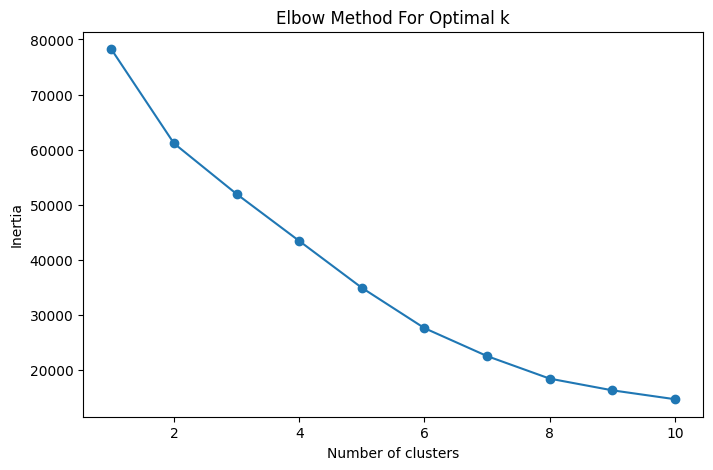

In [ ]:
# Selecting features to include in the clustering
features = ['Median_AQI', 'Days_with_AQI', 'Days_PM2_5', 'Days_Ozone', 'Days_CO', 'Days_NO2', 'Days_PM10']
X = annual_aqi_by_county_df[features]

# scale the features before clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Running K-Means clustering with a range of k to find the optimal number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the elbow plot to find the optimal k
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
# Choosing an appropriate number of clusters
# The inertia decreases rapidly until around k=3 and then begins to level off.
# Although there's not a sharply defined "elbow," the most significant bend in the curve appears at k=3.
# Choosing k=3 is a reasonable starting point based on this plot.
# Beyond k=3, the decrease in inertia becomes more gradual, suggesting that additional clusters are not providing as much new information.

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
annual_aqi_by_county_df['Cluster'] = kmeans.fit_predict(X_scaled)

# Analyzing the clusters
cluster_summary_stats = []

for cluster in range(3):
    cluster_data = annual_aqi_by_county_df[annual_aqi_by_county_df['Cluster'] == cluster]
    stats = cluster_data.describe().reset_index()
    stats['Cluster'] = cluster  # Add a 'Cluster' column to the stats DataFrame
    cluster_summary_stats.append(stats)

cluster_df = pd.concat(cluster_summary_stats).set_index(['Cluster', 'index'])
cluster_df

Year  Days_with_AQI   Good_Days  Moderate_Days  \
Cluster index                                                          
0       count       8420.0         8420.0      8420.0         8420.0   
        mean   2017.936342     322.932779  256.310214      61.974703   
        std       3.150949      65.570416   68.392381      46.124634   
        min         2013.0           31.0         1.0            0.0   
        25%         2015.0          276.0       212.0           27.0   
        50%         2018.0          362.0       270.0           50.0   
        75%         2021.0          365.0       312.0           85.0   
        max         2023.0          366.0       365.0          339.0   
1       count       2497.0         2497.0      2497.0         2497.0   
        mean   2017.961954     243.668803  207.565879      33.930316   
        std       3.149162     121.044366    102.4408      35.652412   
        min         2013.0            1.0         1.0            0.0   
        25%         2015.0          118.0       108.0            6.0   
        50%         2018.0          304.0       228.0           22.0   
        75%         2021.0          361.0       305.0           51.0   
        max         2023.0          366.0       365.0          228.0   
2       count        259.0          259.0       259.0          259.0   
        mean   2017.339768     342.625483  316.250965      23.710425   
        std       3.104198      42.983622    53.77828      34.463062   
        min         2013.0          150.0        60.0            0.0   
        25%         2015.0          347.5       304.5            5.0   
        50%         2017.0          360.0       335.0           13.0   
        75%         2020.0          365.0       350.0           29.0   
        max         2023.0          366.0       365.0          237.0   

               Unhealthy_for_Sensitive_Groups_Days  Unhealthy_Days  \
Cluster index                                                        
0       count                               8420.0          8420.0   
        mean                              3.770071        0.747031   
        std                               9.619232        3.611676   
        min                                    0.0             0.0   
        25%                                    0.0             0.0   
        50%                                    1.0             0.0   
        75%                                    4.0             0.0   
        max                                  122.0            69.0   
1       count                               2497.0          2497.0   
        mean                              1.305166        0.697637   
        std                               3.041346        2.250776   
        min                                    0.0             0.0   
        25%                                    0.0             0.0   
        50%                                    0.0             0.0   
        75%                                    1.0             0.0   
        max                                   26.0            29.0   
2       count                                259.0           259.0   
        mean                              1.517375        0.501931   
        std                               6.093163        1.735124   
        min                                    0.0             0.0   
        25%                                    0.0             0.0   
        50%                                    0.0             0.0   
        75%                                    1.0             0.0   
        max                                   56.0            17.0   

               Very_Unhealthy_Days  Hazardous_Days     Max_AQI  \
Cluster index                                                    
0       count               8420.0          8420.0      8420.0   
        mean               0.09228         0.03848  120.873397   
        std               1.313054        0.556738   66.960245  

In [ ]:
# Group the data by cluster and calculate the average Median AQI
cluster_avg_aqi = annual_aqi_by_county_df.groupby('Cluster')['Median_AQI'].mean().reset_index()

# Create a bar chart
fig = px.bar(cluster_avg_aqi, x='Cluster', y='Median_AQI', text='Median_AQI',
             title='Average Median AQI by Cluster')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

In [ ]:
# Sort the 'Cluster' column
annual_aqi_by_county_df = annual_aqi_by_county_df.sort_values('Cluster')

# Creating a dictionary to hold the results
cluster_dict = {'Cluster': [], 'Counties': [], 'States': []}

# Looping over each cluster to get unique counties and states
for cluster_num in annual_aqi_by_county_df['Cluster'].unique():
    cluster_data = annual_aqi_by_county_df[annual_aqi_by_county_df['Cluster'] == cluster_num]
    unique_counties = list(cluster_data['County'].unique())
    unique_states = list(cluster_data['State'].unique())

    # Appending the results to the dictionary
    cluster_dict['Cluster'].append(cluster_num)
    cluster_dict['Counties'].append(unique_counties)
    cluster_dict['States'].append(unique_states)

# Converting the dictionary to a DataFrame for a nicer display
cluster_summary_df = pd.DataFrame(cluster_dict)
cluster_summary_df

Cluster                                           Counties  \
0        0  [Baldwin, Nowata, Oklahoma, Osage, Pittsburg, ...   
1        1  [Muscatine, St John, Potter, Wasco, Chelan, Mo...   
2        2  [Prowers, Luna, Platte, Santa Cruz, Georgetown...   

                                              States  
0  [Alabama, Oklahoma, Oregon, Pennsylvania, Ohio...  
1  [Iowa, Virgin Islands, Texas, Oregon, Washingt...  
2  [Colorado, New Mexico, Wyoming, Arizona, South...

In [ ]:
cluster_summary_df['Number of Counties'] = cluster_summary_df['Counties'].apply(len)
cluster_summary_df['Number of States'] = cluster_summary_df['States'].apply(len)

# Set the positions for the bars
positions = list(range(len(cluster_summary_df)))

fig = go.Figure()

# Add 'Number of Counties' bar
fig.add_trace(go.Bar(
    x=positions,
    y=cluster_summary_df['Number of Counties'],
    name='Number of Counties',
    marker_color='skyblue',
    text=cluster_summary_df['Number of Counties'],
    hovertemplate='Number of Counties: %{text}<extra></extra>'
))

# Add 'Number of States' bar
fig.add_trace(go.Bar(
    x=positions,
    y=cluster_summary_df['Number of States'],
    name='Number of States',
    marker_color='orange',
    text=cluster_summary_df['Number of States'],
    hovertemplate='Number of States: %{text}<extra></extra>'
))

fig.update_layout(
    barmode='group',
    title='Number of Counties and States in Each Cluster',
    xaxis=dict(
        title='Cluster',
        tickvals=positions,
        ticktext=cluster_summary_df['Cluster'].astype(str)
    ),
    yaxis=dict(title='Count'),
    legend_title_text='Count Type'
)

# Show the figure
fig.show()

In [ ]:
# Dictionary mapping full state names to abbreviations
state_abbr = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA',
    'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT',
    'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM',
    'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
    'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY',
    'District of Columbia': 'DC', 'Puerto Rico': 'PR', 'Virgin Islands': 'VI', 'Country Of Mexico': 'MX'
}

# Initialize a dictionary to store the data
state_cluster_dict = {}

# Iterate over each row of the DataFrame
for index, row in cluster_summary_df.iterrows():
    states = row['States']  # Get the list of states for the current row
    cluster = row['Cluster']  # Get the cluster for the current row
    for state in states:
        state = state.strip()  # Remove leading/trailing whitespaces
        if state in state_abbr:  # Check if the state exists in the abbreviation dictionary
            state_abbrv = state_abbr[state]
            # Add the state and its corresponding cluster to the dictionary
            state_cluster_dict[state_abbrv] = cluster

# Get all unique state abbreviations from the DataFrame
all_states_abbr = set(state_abbr.values())

# Create lists to store state abbreviations and clusters
locations = []
clusters = []
for state_abbrv in all_states_abbr:
    if state_abbrv in state_cluster_dict:
        locations.append(state_abbrv)
        clusters.append(state_cluster_dict[state_abbrv])
    else:
        # If state abbreviation not in the dictionary, assign a default cluster value (e.g., 0)
        locations.append(state_abbrv)
        clusters.append(0)

# Create the Choropleth plot
fig = go.Figure(go.Choropleth(
    locations=locations,
    z=clusters,
    locationmode='USA-states',
    colorscale='Viridis',
    colorbar_title='Cluster',
))

# Update layout
fig.update_layout(
    title_text='Clusters of States by AQI metrics',
    geo_scope='usa',
)

# Show plot
fig.show()


## Correlation analysis

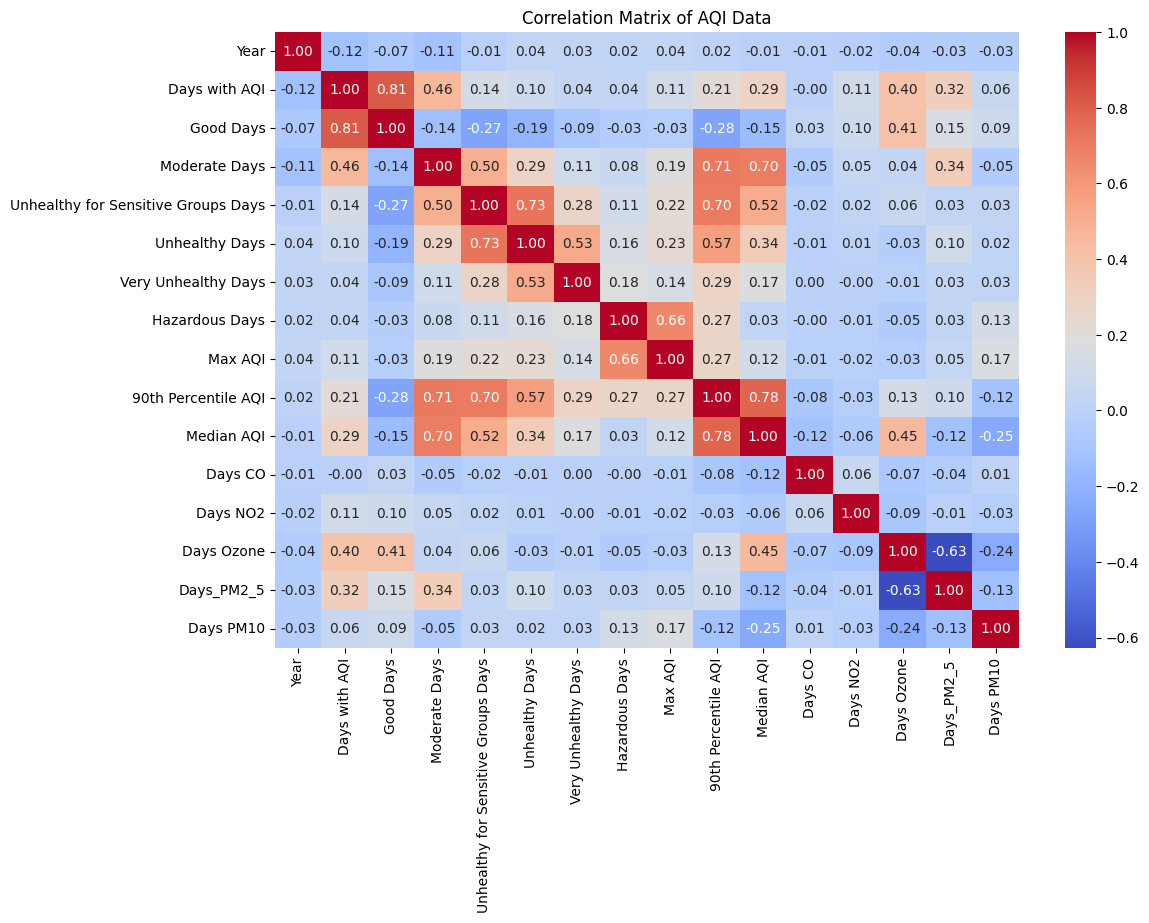

In [ ]:
# Select only numeric columns for correlation calculation
annual_aqi_by_county_numeric_df = annual_aqi_by_county_df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = annual_aqi_by_county_numeric_df.corr()

# Plot a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of AQI Data')
plt.show()

## Feature Importance

<Figure size 1000x600 with 0 Axes>

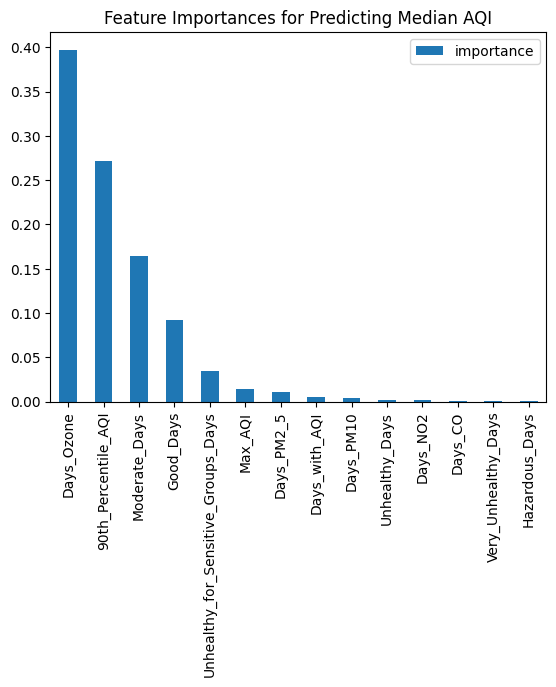

In [ ]:
# Preparing data (dropping any non-numeric or target columns)
X = annual_aqi_by_county_df.drop(['Median_AQI', 'State', 'County', 'Year', 'Cluster'], axis=1)
y = annual_aqi_by_county_df['Median_AQI']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature importance
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Feature Importances for Predicting Median AQI')
plt.show()

## Model Prediction

In [ ]:
# Predict on the test set
y_pred = model.predict(X_test)

# Calculate the accuracy
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 6.589688434130467
Root Mean Squared Error (RMSE): 2.5670388454658157
R-squared (R2): 0.9331184778568484


In [ ]:
# Function to prepare a new data point and predict
def predict_aqi(model, input_data, feature_defaults):
    # Any missing features will be filled in with defaults
    for feature in feature_defaults:
        if feature not in input_data:
            input_data[feature] = feature_defaults[feature]

    # Convert the input data to a DataFrame
    new_data_df = pd.DataFrame([input_data])

    # Predict using the model
    prediction = model.predict(new_data_df)
    return prediction[0]

In [ ]:
# Define the default values for each feature
feature_defaults = {
    'Days_with_AQI': annual_aqi_by_county_df['Days_with_AQI'].mean(),
    'Good_Days': annual_aqi_by_county_df['Good_Days'].mean(),
    'Moderate_Days': annual_aqi_by_county_df['Moderate_Days'].mean(),
    'Unhealthy_for_Sensitive_Groups_Days': annual_aqi_by_county_df['Unhealthy_for_Sensitive_Groups_Days'].mean(),
    'Unhealthy_Days': annual_aqi_by_county_df['Unhealthy_Days'].mean(),
    'Very_Unhealthy_Days': annual_aqi_by_county_df['Very_Unhealthy_Days'].mean(),
    'Hazardous_Days': annual_aqi_by_county_df['Hazardous_Days'].mean(),
    'Max_AQI': annual_aqi_by_county_df['Max_AQI'].mean(),
    '90th_Percentile_AQI': annual_aqi_by_county_df['90th_Percentile_AQI'].mean(),
    'Days_CO': annual_aqi_by_county_df['Days_CO'].mean(),
    'Days_NO2': annual_aqi_by_county_df['Days_NO2'].mean(),
    'Days_Ozone': annual_aqi_by_county_df['Days_Ozone'].mean(),
    'Days_PM2_5': annual_aqi_by_county_df['Days_PM2_5'].mean(),
    'Days_PM10': annual_aqi_by_county_df['Days_PM10'].mean(),
}

In [ ]:
sample_input = {
    'Days_with_AQI': 250,
    'Good_Days': 200,
    'Moderate_Days': 45,
    'Unhealthy_for_Sensitive_Groups_Days': 3,
    'Unhealthy_Days': 1,
    'Very_Unhealthy_Days': 1,
    'Hazardous_Days': 0,
    'Max_AQI': 150,
    '90th_Percentile_AQI': 80,
    'Days_CO': 0,
    'Days_NO2': 0,
    'Days_Ozone': 100,
    'Days_PM2_5': 45,
    'Days_PM10': 5,
}

# Make a prediction
predicted_aqi = predict_aqi(model, sample_input, feature_defaults)
print(f"The predicted Median AQI for the new data point is: {predicted_aqi}")

The predicted Median AQI for the new data point is: 41.64
